<a target="_blank" href="https://colab.research.google.com/github/lukebarousse/Python_Data_Analytics_Course/blob/main/3_Project/2_Skill_Demand.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final findings

#### Original Exploration
[13_Matplotlib_Format_Charts.ipynb](../2_Advanced/13_Matplotlib_Format_Charts.ipynb)

## Import Libraries and Data

In [2]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

c:\Users\EliteBook mt44\anaconda3\envs\python_course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Filter Data for the United States

Filter the data for the market of the United States.

In [3]:
df_CA = df[df['job_country'] == 'Canada']

## Explode Skills

Converts the `job_skills` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the `job_title` and `job_skills` columns, allowing us to analyze the distribution of skills across different data job titles.

In [4]:
df_skills = df_CA.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
50,Sr ML Engineer - Research & NLP (Remote),python
50,Sr ML Engineer - Research & NLP (Remote),sql
50,Sr ML Engineer - Research & NLP (Remote),pytorch
50,Sr ML Engineer - Research & NLP (Remote),pandas
59,Data Engineer with Dremio Experience,sql
...,...,...
785511,Data Engineer,spark
785511,Data Engineer,airflow
785511,Data Engineer,kafka
785643,Analyste,word


## Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.

In [5]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1215,sql,Data Engineer,3794
949,python,Data Engineer,3567
108,azure,Data Engineer,2217
98,aws,Data Engineer,2030
1171,spark,Data Engineer,1948
...,...,...,...
749,no-sql,Cloud Engineer,1
748,no-sql,Business Analyst,1
671,mattermost,Senior Data Analyst,1
1439,webex,Data Scientist,1


## Create List of Top 3 Roles

#### Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [6]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Senior Data Engineer']

## Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

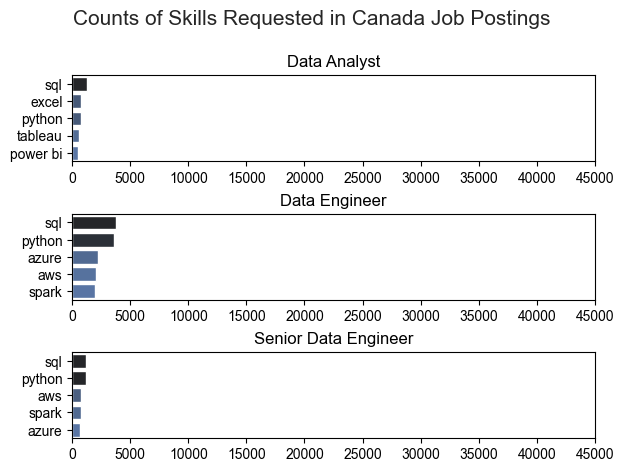

In [7]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in Canada Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages

#### Focus: Counts don't show what portions of jobs are requesting these skills

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the `value_counts()` method on the `job_title_short` column. Then reset the index to transform the Series into a DataFrame and renames the columns to `job_title_short` and `total`. The DataFrame `df_job_title_count` now holds a list of job titles alongside their total occurrences.

In [10]:
# Use original df to get the count of job titles
df_job_title_count = df_CA['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,5828
1,Data Analyst,2365
2,Data Scientist,1825
3,Senior Data Engineer,1776
4,Software Engineer,1254
5,Business Analyst,1109
6,Senior Data Scientist,589
7,Machine Learning Engineer,566
8,Senior Data Analyst,435
9,Cloud Engineer,282


Then we calculate the percentages. First merge `df_skills_count` and `df_job_title_count`, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [11]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,3794,5828,65.099520
1,python,Data Engineer,3567,5828,61.204530
2,azure,Data Engineer,2217,5828,38.040494
3,aws,Data Engineer,2030,5828,34.831846
4,spark,Data Engineer,1948,5828,33.424846
...,...,...,...,...,...
1480,no-sql,Cloud Engineer,1,282,0.354610
1481,no-sql,Business Analyst,1,1109,0.090171
1482,mattermost,Senior Data Analyst,1,435,0.229885
1483,webex,Data Scientist,1,1825,0.054795


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

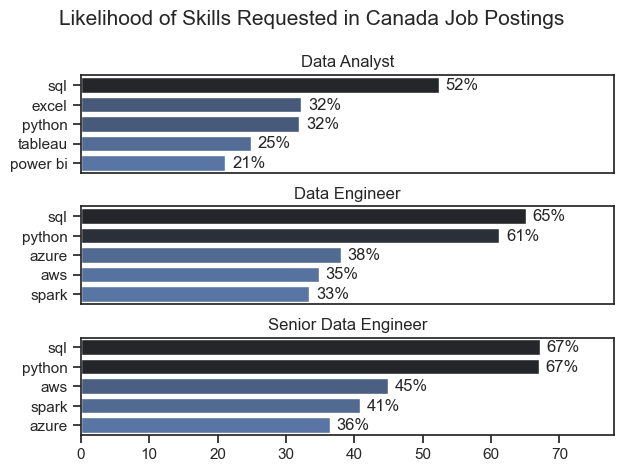

In [12]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in Canada Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()